# **Proyecto de Simulación en Negocios: Performance de la turbina de viento en la Patagonia**

Integrantes: Micaela Oliva, Camila Bernardez, Sol Valeggia, Juan Castore

## **Overview del Proyecto**
Este notebook tiene como objetivo analizar y optimizar la performance operativa y económica de dos molinos de viento ubicados en la Patagonia. El análisis incluirá la estimación de parámetros, la simulación de patrones de viento, y la optimización de estrategias operativas para maximizar el Valor Actual Neto (VAN) de los molinos.

### **Tabla de Contenidos**
1. [Introducción](#Introducción)
2. [Preprocesamiento de Datos](#Preprocesamiento-de-Datos)
3. [Ejercicio 1: Estimación de Parámetros](#Ejercicio-1)
4. [Ejercicio 2: Simulación de Patrones de Viento](#Ejercicio-2)
5. [Ejercicio 3: Simulación de Operaciones de los Molinos](#Ejercicio-3)
6. [Ejercicio 4: Análisis de la Evolución del Estado de los Molinos](#Ejercicio-4)
7. [Ejercicio 5: Cálculo del VAN Esperado](#Ejercicio-5)
8. [Ejercicio 6: Optimización del Umbral de Operación](#Ejercicio-6)
9. [Ejercicio 7: Comparación con la Operación Ingenua](#Ejercicio-7)
10. [Ejercicio 8: Distribución de Ingresos de Agosto](#Ejercicio-8)
11. [Ejercicio 9: Análisis de Roturas](#Ejercicio-9)
12. [Ejercicio 10: Días Inactivos](#Ejercicio-10)
12. [Ejercicio 11: Probabilidades de Inactividad](#Ejercicio-11)
13. [Ejercicio 12: Correlación de Ingresos](#Ejercicio-12)
14. [Ejercicio 13: Sensibilidad al Costo de Reparación](#Ejercicio-13)
15. [Ejercicio 14: Sensibilidad a la Media Estacional](#Ejercicio-14)
16. [Conclusión](#Conclusión)

## **Introducción** <a name="Introducción"></a>
- **Objetivo:** Brindar un resumen del proyecto y sus metas.
- **Planteamiento del Problema:** Discutir el problema, incluyendo la importancia de optimizar las operaciones de los molinos de viento.

## **Preprocesamiento de Datos** <a name="Preprocesamiento-de-Datos"></a>
- **Carga e Inspección de Datos:** Cargar los datos de velocidad del viento e inspeccionarlos para detectar inconsistencias o valores faltantes.
- **Visualización de Datos:** Graficar los datos de velocidad del viento para comprender las tendencias subyacentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(123)

In [2]:
# Carga de datos
wind = pd.read_excel('Wind data for TP1.xlsx')

In [3]:
# Vemos las primeras filas
wind.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [4]:
# Identificar valores faltantes
missing_values = wind.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 dia                   0
regional wind         0
wind gap norte sur    0
dtype: int64


No tiene valores missing.

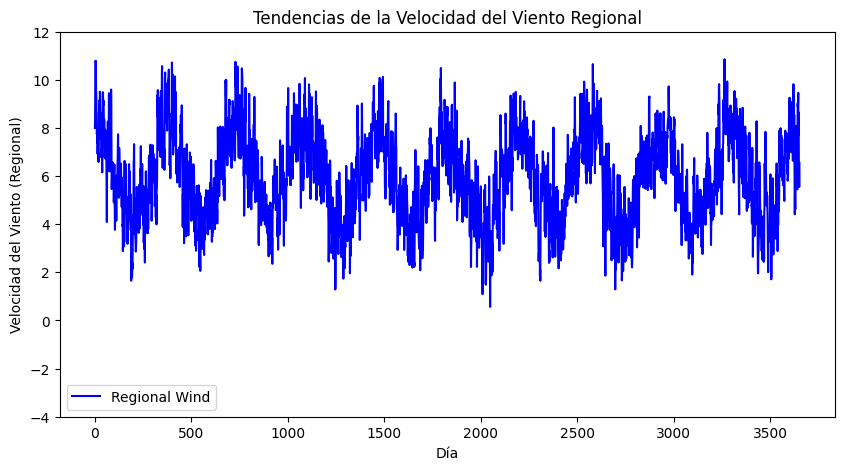

In [5]:
# Visualización de la columna 'regional wind'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['regional wind'], label='Regional Wind', color='blue')
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento (Regional)')
plt.title('Tendencias de la Velocidad del Viento Regional')
plt.ylim(-4, 12)
plt.legend()
plt.show()

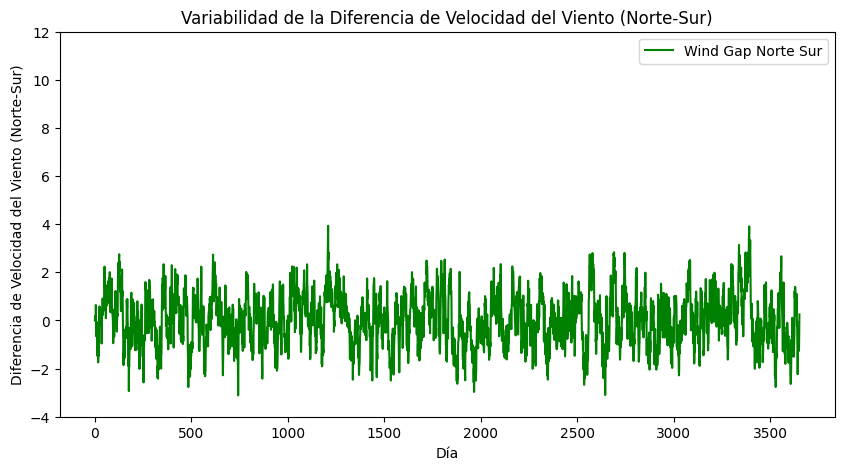

In [6]:
# Visualización de la columna 'wind gap norte sur'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['wind gap norte sur'], label='Wind Gap Norte Sur', color='green')
plt.xlabel('Día')
plt.ylabel('Diferencia de Velocidad del Viento (Norte-Sur)')
plt.title('Variabilidad de la Diferencia de Velocidad del Viento (Norte-Sur)')
plt.ylim(-4, 12)
plt.legend()
plt.show()


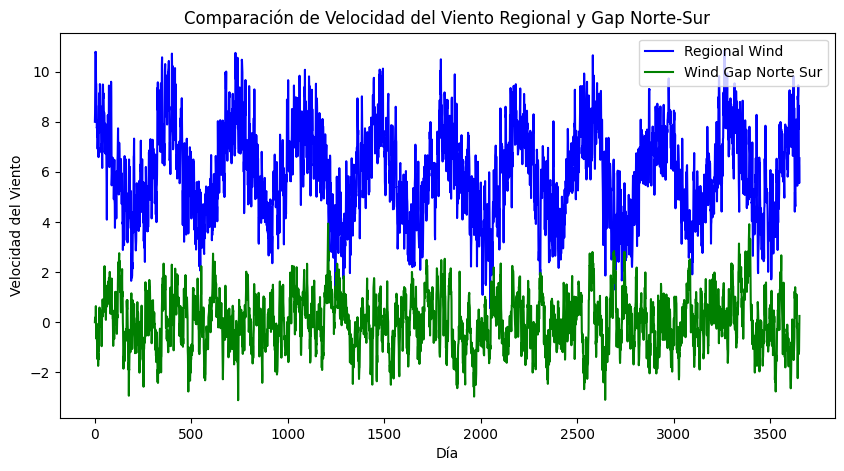

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['regional wind'], label='Regional Wind', color='blue')
plt.plot(wind['dia'], wind['wind gap norte sur'], label='Wind Gap Norte Sur', color='green')
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación de Velocidad del Viento Regional y Gap Norte-Sur')
plt.legend()
plt.show()

## **Ejercicio 1: Estimación de Parámetros** <a name="Ejercicio-1"></a>
- **Modelo de Viento Regional:**
  - Especificar el modelo $( S_{i+1} = S_i + \kappa(\theta(t_i) - S_i)\Delta + \sigma\sqrt{\Delta}Z_i)$ para el viento regional.
  - Implementar la regresión lineal para estimar los parámetros $( \kappa )$ y $( \sigma )$.
- **Modelo de Diferencia de Viento entre Molinos:**
  - Especificar el modelo $(D_{i+1} = D_i - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i)$ para la diferencia de viento.
  - Implementar la regresión lineal para estimar los parámetros $(\beta)$ y $( \gamma)$.
- **Resultados:**
  - Presentar los parámetros estimados $( \kappa), ( \sigma ), ( \beta )$ y $( \gamma)$, junto con sus errores estándar.


## Especificación del modelo de Viento Regional

#### Aislamos los parámetros a estimar 

$$ S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

$$ S_{i+1} - S_i = \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

Si tomamos $Y_i = S_{i+1} - S_i$, $X_i = (\theta - S_i) \Delta$ y $c = \sigma \sqrt{\Delta}\cdot Z_i$ podemos reescribir la ecuación como:

$$ Y_i = \kappa X_i + c $$

In [24]:
#Regresión lineal del viento regional y estimaciones de kappa y sigma
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

delta = 1/365
theta_est = 6 + (2 * np.cos((2 * np.pi * wind["dia"])/365))
Y = (wind["regional wind"][1:] - wind["regional wind"].shift(1)[1:]).values
X = ((theta_est.mean() - wind["regional wind"][:-1])*delta).values

model = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = model.predict(X.reshape(-1,1))

# Estimación de kappa y c
kappa_est = model.coef_[0]

c_est = np.sqrt(mean_squared_error(Y, Y_pred))

# Estimación de sigma
sigma_est = c_est / np.sqrt(delta)

print(theta_est.mean())
print(kappa_est)
print(sigma_est)

6.0
46.623981748232275
16.83825612343234


## Especificación del modelo de la diferencia de molinos

#### Aislamos los parámetros a estimar 

$$ D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

$$ D_{i+1} - D_i = \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

Si tomamos $R_i = D_{i+1} - D_i$, $Q_i = D_i \Delta$ y $c = \gamma \sqrt{\Delta} W_{i}$ podemos reescribir la ecuación como:

$$ R_i = \beta Q_i + c $$

In [9]:
#Regresión lineal para la diferencia de vientos entre molinos y estimaciones de beta y gamma
delta = 1/365
R = (wind["wind gap norte sur"][1:] - wind["wind gap norte sur"].shift(1)[1:]).values
Q = (wind["wind gap norte sur"][1:]*delta).values

model2 = LinearRegression().fit(Q.reshape(-1,1), R)
R_pred = model2.predict(Q.reshape(-1,1))

# Estimación de kappa y c
beta_est = model2.coef_[0]
c_est2 = np.sqrt(mean_squared_error(R, R_pred))

# Estimación de sigma
gamma_est = c_est2 / np.sqrt(delta)

print(beta_est)
print(gamma_est)

48.38096395344706
10.090662101680072


## **Ejercicio 2: Simulación de Patrones de Viento** <a name="Ejercicio-2"></a>
- **Simulación de la Velocidad del Viento:**
  - Implementar una simulación para la velocidad diaria del viento en ambos molinos durante un año, utilizando los parámetros estimados.
- **Comparación con Datos Históricos:**
  - Comparar la velocidad del viento simulada con los datos históricos utilizando gráficos y pruebas estadísticas apropiadas.


[[ 8.          8.29699716  7.4981852  ...  9.71789045  9.93439419
   9.23073824]
 [ 8.          8.89394084  8.20195847 ...  6.62800078  7.60740436
   7.61188859]
 [ 8.          6.60070326  5.28799677 ...  5.1545416   6.20823419
   7.02321215]
 ...
 [ 8.          9.80873261  9.41766113 ...  7.67440931  7.28518562
   6.35568281]
 [ 8.          8.18361033  9.58293698 ...  9.94767705  8.88715366
   9.97744316]
 [ 8.          8.06650475 11.03520519 ...  7.7311168   8.5377012
   8.55266969]]


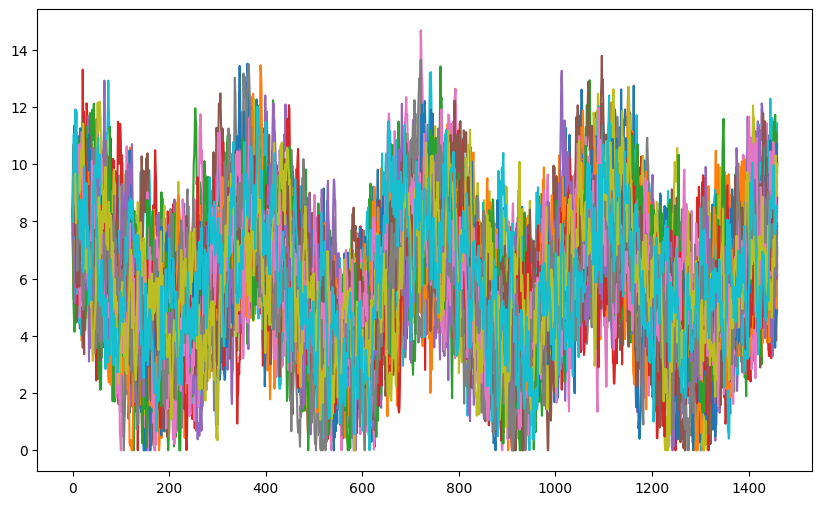

In [32]:
#Simulación de molino N
#m = caminos
#T = tiempo
#Hicimos que tita sea el promedio, chequear que este bien
def molino_N(S_0, kappa, theta, delta, sigma, m, T):
    S = np.zeros((m, T))
    S[:, 0] = S_0
    for i in range(m):
        for t in range(1, T):
            S[i, t] = S[i, t-1] + (kappa * (theta[t-1] - S[i, t-1]) * delta ) + np.sqrt(delta) * sigma * np.random.normal(0, 1)
            if S[i, t] < 0:
                S[i, t] = 0
    return S

N_0 = wind["regional wind"].iloc[0]
N = molino_N(N_0, kappa_est, theta_est, delta, sigma_est, 30, 365*4)
print(N)
plt.figure(figsize=(10,6))
for i in range(30):
    plt.plot(N[i])
plt.show()

In [ ]:
def molino_N(S_0, kappa, theta, delta, sigma, gamma, beta, m, T):
    S = np.zeros((m, T))
    S[:, 0] = S_0
    for i in range(m):
        for t in range(1, T):
            S[i, t] = S[i, t-1] + (kappa * (theta[t-1] - S[i, t-1]) * delta ) + np.sqrt(delta) * sigma * np.random.normal(0, 1)
            if S[i, t] < 0:
                S[i, t] = 0
    return S

N_0 = wind["regional wind"].iloc[0]
N = molino_N(N_0, kappa_est, theta_est, delta, sigma_est, 50, 365)
print(N)
plt.figure(figsize=(10,6))
for i in range(50):
    plt.plot(N[i])
plt.show()

## **Ejercicio 3: Simulación de Operaciones de los Molinos** <a name="Ejercicio-3"></a>
- **Simulación de las Operaciones de los Molinos:**
  - Simular la evolución diaria del viento en cada molino, incluyendo la simulación de fallas, decisiones de apagado/encendido, y acumulación de cashflows.

  

## **Ejercicio 4: Análisis de la Evolución del Estado de los Molinos** <a name="Ejercicio-4"></a>
- **Evolución del Estado de los Molinos:**
  - Graficar la evolución del estado de cada molino (activo/inactivo, roturas) a lo largo de un año, utilizando un camino típico del viento simulado.
  - Analizar si los resultados tienen sentido desde el punto de vista operativo.


## **Ejercicio 5: Cálculo del VAN Esperado** <a name="Ejercicio-5"></a>
- **VAN como Función del Umbral de Operación:**
  - A partir de un número grande de simulaciones, calcular el Valor Actual Neto (VAN) esperado como función del umbral de apagado/encendido.


## **Ejercicio 6: Optimización del Umbral de Operación** <a name="Ejercicio-6"></a>
- **Umbral Óptimo:**
  - Determinar el valor óptimo del umbral de apagado y encendido que maximiza el VAN esperado durante un año.

## **Ejercicio 7: Comparación con la Operación Ingenua** <a name="Ejercicio-7"></a>
- **Comparación de Estrategias:**
  - Comparar la ganancia en VAN al utilizar la estrategia óptima versus una operación ingenua que nunca apaga los molinos.


## **Ejercicio 8: Distribución de Ingresos de Agosto** <a name="Ejercicio-8"></a>
- **Distribución de Ingresos:**
  - Calcular y graficar la distribución del ingreso total durante el mes de agosto (sin descontar) bajo el umbral de operación óptimo.


## **Ejercicio 9: Análisis de Roturas** <a name="Ejercicio-9"></a>
- **Número Medio de Roturas:**
  - Calcular el número medio de roturas por año que sufre cada molino bajo la estrategia óptima y compararlo con el caso en que nunca se apagan.


## **Ejercicio 10: Días Inactivos** <a name="Ejercicio-10"></a>
- **Días Inactivos:**
  - Calcular el número medio de días por año en que cada molino está inactivo, ya sea por apagado voluntario o rotura.



## **Ejercicio 11: Probabilidades de Inactividad** <a name="Ejercicio-11"></a>
- **Probabilidades de Inactividad:**
  - Calcular la probabilidad de que ambos molinos estén inactivos el 9 de julio y en cualquier día del año.

## **Ejercicio 12: Correlación de Ingresos** <a name="Ejercicio-12"></a>
- **Correlación entre Molinos:**
  - Calcular la correlación entre los ingresos totales mensuales de mayo de los dos molinos.


## **Ejercicio 13: Sensibilidad al Costo de Reparación** <a name="Ejercicio-13"></a>
- **Análisis de Sensibilidad al Costo de Reparación:**
  - Analizar cómo afecta al VAN y al umbral óptimo un aumento en el costo de reparación a 250 mil dólares.


## **Ejercicio 14: Sensibilidad a la Media Estacional** <a name="Ejercicio-14"></a>
- **Análisis de Sensibilidad a la Media Estacional:**
  - Explorar cómo afectan los cambios en la media estacional del viento al VAN y a las decisiones operativas.


## **Conclusión** <a name="Conclusión"></a>
- **Resumen de Resultados:**
  - Resumir los principales hallazgos del análisis, incluyendo la estrategia operativa óptima.
- **Perspectivas de Negocio:**
  - Discutir cualquier insight adicional obtenido del análisis.
- **Próximos Pasos:**
  - Sugerir posibles mejoras o análisis adicionales que podrían realizarse.


### **Apéndice**